In [2]:
# pip install pycaret

In [3]:
from pycaret.classification import *

In [4]:
from pandas_profiling import ProfileReport
import numpy as np
import pandas as pd

In [6]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('./Datasets/classification/Data_4.csv')
# train, test = train_test_split(data, test_size = 0.2, random_state=42)
# data

In [7]:
data.head()
x_train = data.drop(['X2urvived' ,'Unnamed: 0'],axis=1)
y_train = data['X2urvived']
# x_test= test.drop(['X2urvived' ,'Unnamed: 0'],axis=1)
# y_test = test['X2urvived']

In [8]:
exp1 = setup(data, target = 'X2urvived', session_id=123, verbose = False)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Unnamed: 0,ID Column
Age,Numeric
Fare,Numeric
Sex,Categorical
sibsp,Numeric
Parch,Numeric
Pclass,Numeric
Embarked,Numeric
X2urvived,Label


In [11]:
gbm_boost = create_model('lightgbm', method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8440,0.9130,0.8545,0.8393,0.8468,0.6880,0.6881
1,0.8257,0.9096,0.9273,0.7727,0.8430,0.6507,0.6644
2,0.7890,0.8641,0.7636,0.8077,0.7850,0.5782,0.5790
3,0.9074,0.9372,0.9273,0.8947,0.9107,0.8146,0.8152
4,0.8981,0.9590,0.8727,0.9231,0.8972,0.7964,0.7977
5,0.8333,0.8844,0.8909,0.8033,0.8448,0.6659,0.6700
6,0.8704,0.9393,0.9273,0.8361,0.8793,0.7401,0.7448
7,0.8056,0.9115,0.9259,0.7463,0.8264,0.6111,0.6296
8,0.7407,0.8059,0.7778,0.7241,0.7500,0.4815,0.4828
9,0.8333,0.8999,0.8333,0.8333,0.8333,0.6667,0.6667


In [12]:
gbm_final = finalize_model(gbm_boost)

In [14]:
predictions = predict_model(gbm_final ,data = data)
predictions.describe()

,Unnamed: 0,Age,Fare,Sex,sibsp,Parch,Pclass,Embarked,X2urvived,Label,Score
count,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000
mean,773.500000,0.355899,0.076246,0.457364,0.501292,0.428295,2.202842,1.434755,0.500000,0.509690,0.865480
std,447.013423,0.166083,0.121674,0.498340,0.982391,0.835941,0.860055,0.845693,0.500162,0.500068,0.125835
min,0.000000,0.002125,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.503700
25%,386.750000,0.262500,0.015713,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.791500
50%,773.500000,0.350000,0.033279,0.000000,0.000000,0.000000,2.000000,2.000000,0.500000,1.000000,0.915600
75%,1160.250000,0.437500,0.077294,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,0.962600
max,1547.000000,1.000000,1.000000,1.000000,8.000000,9.000000,3.000000,2.000000,1.000000,1.000000,0.997200


In [16]:
test_data = pd.read_csv('./Datasets/classification/Normalized_test.csv')
x_test = test_data.drop(['X2urvived', 'Unnamed: 0'], axis=1)
y_test = test_data['X2urvived']

In [18]:
from timeit import default_timer as timer
from cxplain.util.test_util import TestUtil

In [19]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from tensorflow.python.keras.losses import categorical_crossentropy
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain

Instructions for updating:
non-resource variables are not supported in the long term


In [20]:
explained_model  = gbm_final
model_builder = MLPModelBuilder(num_layers=1, num_units=64, batch_size=1200,activation= 'relu', p_dropout=0.2, optimizer="rmsprop",num_epochs=15,early_stopping_patience=3, learning_rate=0.001, verbose=True)
masking_operation = ZeroMasking()
loss =categorical_crossentropy

In [22]:
explainer = CXPlain(explained_model, model_builder, masking_operation, loss, num_models=2, flatten_for_explained_model=True)

In [23]:
start = timer()
explainer.fit(x_train.to_numpy(), y_train.to_numpy())
stop = timer()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1393 samples, validate on 155 samples
Epoch 1/15
1393/1393 [==============================] - 1s 691us/sample - loss: 1.0259 - dense_1_loss: 0.1055 - all_loss: 0.5222 - lambda_1_loss: 0.3923 - val_loss: 1.2917 - val_dense_1_loss: 0.0824 - val_all_loss: 0.3898 - val_lambda_

In [24]:
stop - start

5.396310962998541

In [28]:
attributions, confidence = explainer.explain(x_test.to_numpy(), confidence_level = 0.70)

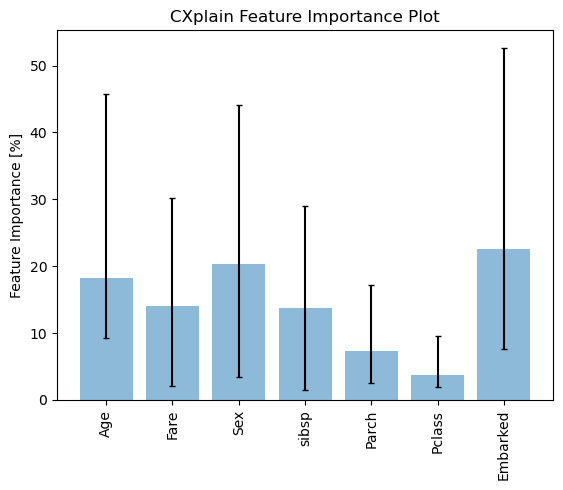

<Figure size 640x480 with 0 Axes>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from cxplain.visualisation.plot import Plot

plt.rcdefaults()

# feature_names = TestUtil.get_boston_housing_feature_names()
# x_test = x_test.to_numpy()
np.random.seed(100)
selected_index = np.random.randint(len(x_test))
selected_sample = x_test.to_numpy()[selected_index]
importances = attributions[selected_index]*100
importances_confidence = confidence[selected_index]*100
feature_names = ['Age','Fare','Sex','sibsp','Parch','Pclass','Embarked']
Plot.plot_attribution_1d(selected_sample, importances, importances_confidence,
                         title='CXplain Feature Importance Plot'.format(selected_index), feature_names=feature_names)